# Model interpretation

In [118]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance

In [103]:
MODELS = "../models/"
DATA = "../data/"
PROCESSED = DATA + "processed/"
RANDOM_STATE = 1

In [104]:
np.random.seed(RANDOM_STATE)


## Most predictive words of fake news.
We analyze the weights of the best __Logistic Regression__ to find which words are the most indicative of fake news and real news. According to the results obtained in the the `model_evaluation.ipynb` notebook, Logistic Regression with L2 penalty had slightly greater scores in all performance metrics so we use it for interpretation.

In [105]:
# Load the model
lr_l2 = joblib.load(MODELS + "lr_l2.pkl")

# Load the vectorizer object to map column indices back to their corresponding words
vectorizer = joblib.load(DATA + "vectorizer.pkl")

In [106]:
features = vectorizer.get_feature_names_out()
l2_weights = lr_l2.coef_[0]


In [107]:
# Sort the indexes of the weights by their corresponding weight value
idx_sorted = np.argsort(l2_weights)

# The largest weights will be at the end of the array
fake_news_idx = idx_sorted[-10:]
fake_news_words = [features[idx] for idx in fake_news_idx]
fake_news_weights = [l2_weights[idx] for idx in fake_news_idx]

# The smallest weights will be in the beggining of the array
real_news_idx = idx_sorted[:10]
real_news_words = [features[idx] for idx in real_news_idx]
real_news_weights = [l2_weights[idx] for idx in real_news_idx]

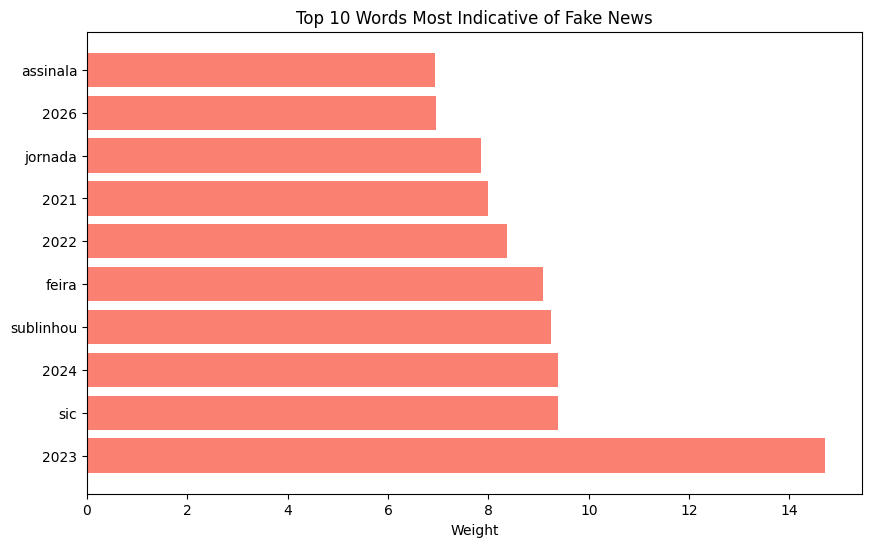

In [108]:
plt.figure(figsize=(10,6))
plt.barh(fake_news_words, fake_news_weights, color='salmon')
plt.xlabel('Weight')
plt.title('Top 10 Words Most Indicative of Fake News')
plt.gca().invert_yaxis() 
plt.show()

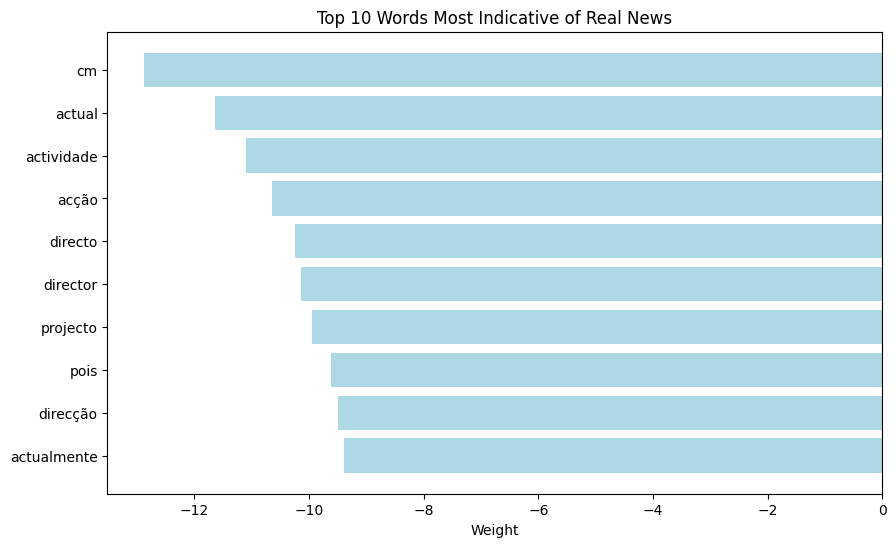

In [109]:
plt.figure(figsize=(10,6))
plt.barh(real_news_words, real_news_weights, color='lightblue')
plt.xlabel('Weight')
plt.title('Top 10 Words Most Indicative of Real News')
plt.gca().invert_yaxis() 
plt.show()

## Comparing number of non-zero weights in Logistic Regression with L1 and L2 penalty

In [110]:
# Load Logistic Regression with L1 penalty
lr_l1 = joblib.load(MODELS + "lr_l1.pkl")

In [111]:
threshold = 0.0001
l1_weights = lr_l1.coef_[0]

l1_non_zero_weights = len([w for w in l1_weights if abs(w) > threshold])
l2_non_zero_weights = len([w for w in l2_weights if abs(w) > threshold])

print("Number of non zero weights in Logistic Regression:")
print("\tL1 penalty: ", l1_non_zero_weights)
print("\tL2 penalty: ", l2_non_zero_weights)

Number of non zero weights in Logistic Regression:
	L1 penalty:  2019
	L2 penalty:  4999


## Explaining model classifications with specific observations


To explain and understand a model's classification use LIME. First let us load the validation dataset and define a function that takes a function into account

In [112]:
# Load validation dataset
df_validation = pd.read_csv(PROCESSED + "validation_features.csv")
X_validation = df_validation.drop(columns=["Label"])
y_validation = df_validation["Label"]

In [113]:
selected_ids = [2921, 2437, 5557, 1697]

In [114]:
def lime_explain(model, num_features):
    """
    This function was created to explain Logistic Regression (L2 penalty) and MLP without having to repeat code

    Args:
        model (_type_): _description_
        num_features (_type_): _description_

    """

    explainer = LimeTabularExplainer(
        training_data=X_validation.values,
        feature_names=X_validation.columns.tolist(),
        class_names=[str(c) for c in model.classes_],
        mode='classification',
        random_state=RANDOM_STATE
    )

    def predict_fn(x):
        df = pd.DataFrame(x, columns=X_validation.columns)
        return model.predict_proba(df)

    for idx in selected_ids:
        row = X_validation.loc[[idx]]

        exp = explainer.explain_instance(
            data_row=row.values[0],
            predict_fn=predict_fn,
            num_features=num_features
        )

        exp_list = exp.as_list()
        readable_exp = []
        for feature, weight in exp_list:
            col_idx = int(feature.split()[0])
            word = features[col_idx]
            readable_exp.append((word, weight))

        words, weights = zip(*readable_exp)

        # Plot
        plt.figure(figsize=(7, 4))
        plt.barh(words, weights)
        plt.xlabel("Feature weight")
        plt.title(f"LIME explanation for ID {idx} - Model: {model.__class__.__name__}")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

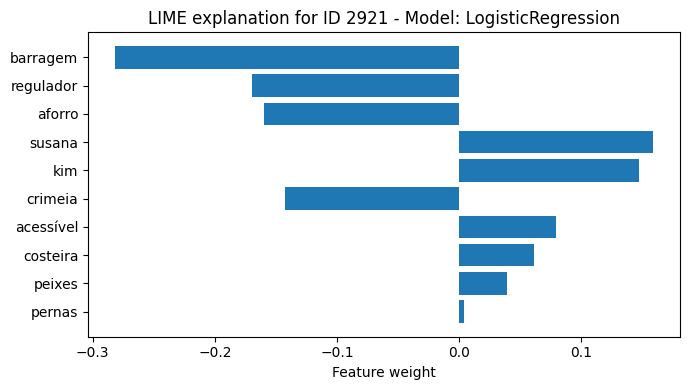

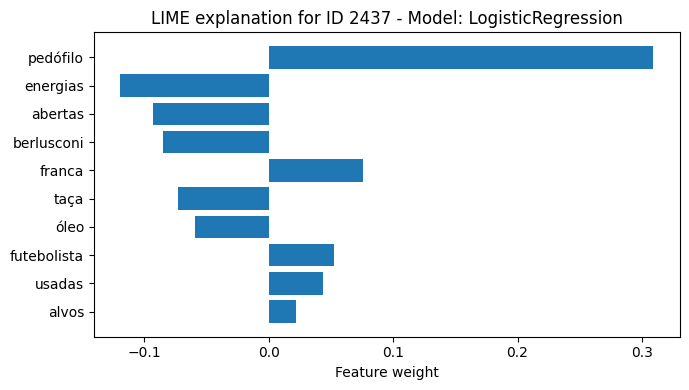

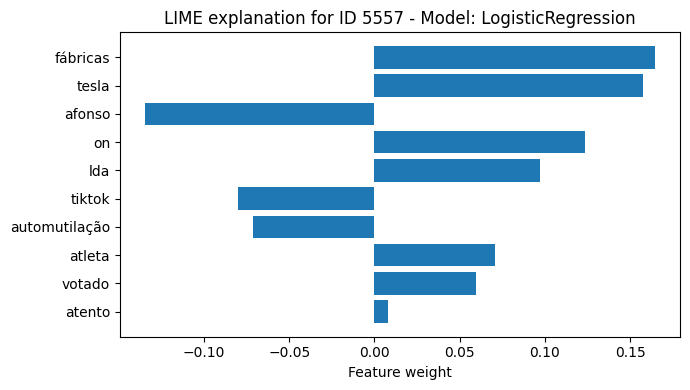

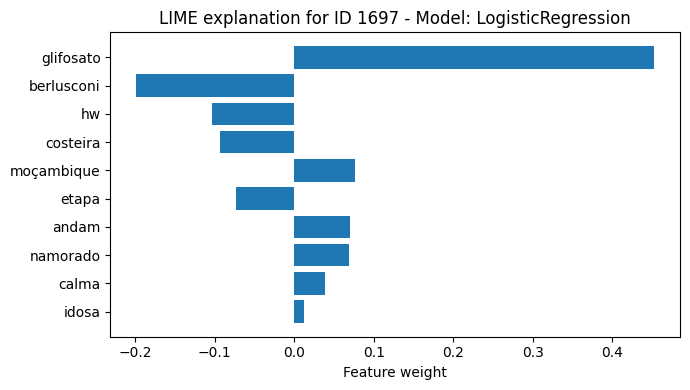

In [115]:
lime_explain(lr_l2, 10)

In [116]:
# Load mlp model
mlp = joblib.load(MODELS + "mlp.pkl")

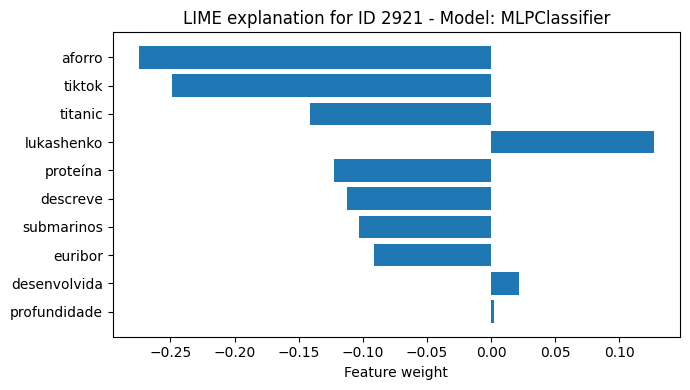

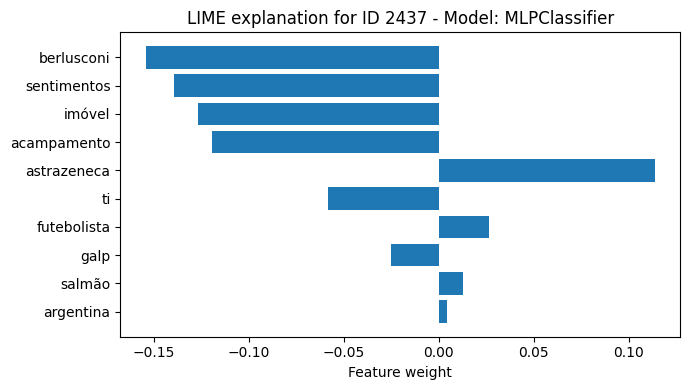

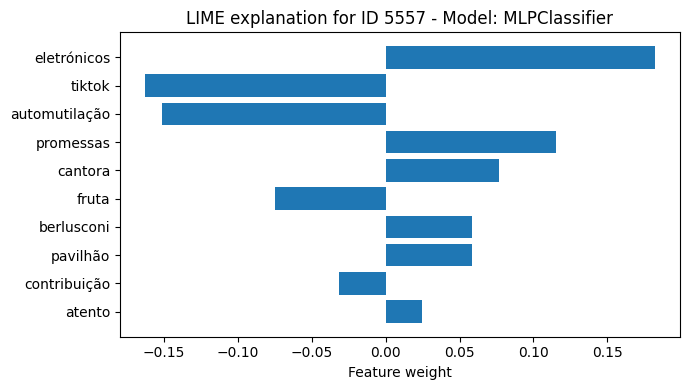

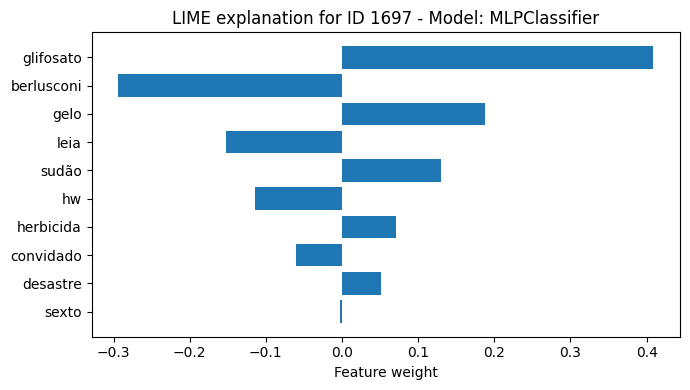

In [117]:
lime_explain(mlp, 10)

### Using permutation importance to measure the influence of features

In [120]:
n_random_samples = 1000

X_subset = X_validation.sample(n=n_random_samples, random_state=42)
y_subset = y_validation.loc[X_subset.index]

result = permutation_importance(
    mlp,
    X_validation,
    y_validation,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="f1_macro"
)

importances = result.importances_mean

feature_names = features 
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

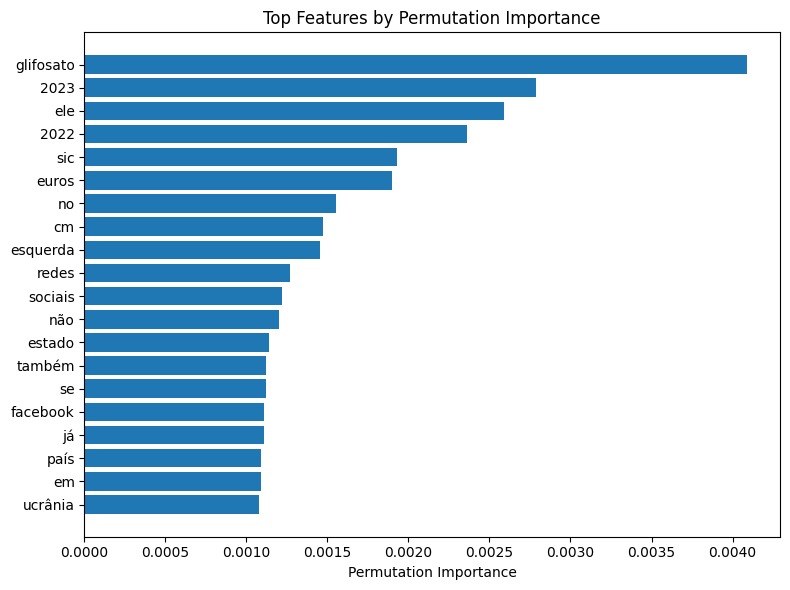

In [121]:

top_n = 20
top_features = importance_df.head(top_n)
plt.figure(figsize=(8, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top Features by Permutation Importance")
plt.tight_layout()
plt.show()